# Customer Churn Prediction for Telecom Provider: Interconnect

In this project, we will develop a machine learning model to predict customer churn for the telecom provider Interconnect. If a customer is likely to leave, the company can proactively offer promotions or better plans to retain them.

**Goal** 

The target variable is churn, defined as customers whose `EndDate` is "No" (they are still active).
Our main objective is to build a predictive model that maximizes the AUC-ROC score, with a minimum threshold of 0.75 for project approval.

**Evaluation Criteria** 

We will evaluate model performance based on:

- Primary Metric: AUC-ROC Score
- Secondary Metric: Accuracy

The scoring system is:

- AUC-ROC < 0.75 → 0 SP (Fail)
- 0.75 ≤ AUC-ROC < 0.81 → 4 SP
- 0.81 ≤ AUC-ROC < 0.85 → 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 → 5 SP
- 0.87 ≤ AUC-ROC < 0.88 → 5.5 SP
- AUC-ROC ≥ 0.88 → 6 SP (Highest Score)

**Project Workflow** 

- Data Loading & Exploration – Load and inspect datasets.
- Data Preprocessing – Handle missing values, merge datasets, and clean columns.
- Exploratory Data Analysis (EDA) – Identify trends and correlations.
- Feature Engineering – Transform categorical and numerical features.
- Model Development – Train and evaluate machine learning models.
- Final Evaluation & Conclusion – Optimize the model and summarize findings.


***
### Load the Data and Explore General Information
- Load all four datasets.
- Display basic information such as the number of rows, columns, and data types.
- Check for missing values.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Display settings
pd.set_option('display.max_columns', None) 
pd.set_option('display.float_format', '{:.2f}'.format)

# Load datasets
contract_df = pd.read_csv("contract.csv")
personal_df = pd.read_csv("personal.csv")
internet_df = pd.read_csv("internet.csv")
phone_df = pd.read_csv("phone.csv")

# Display first few rows of each dataset
display(contract_df.head(), personal_df.head(), internet_df.head(), phone_df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [2]:
# Function to summarize datasets
def dataset_info(df, name):
    print(f"Dataset: {name}")
    print("-" * 40)
    print(f"Shape: {df.shape}")
    print("\nMissing values:")
    print(df.isnull().sum())
    print("\nData Types:")
    print(df.dtypes)
    print("\n" + "="*60 + "\n")

# Display info for each dataset
dataset_info(contract_df, "Contract")
dataset_info(personal_df, "Personal")
dataset_info(internet_df, "Internet")
dataset_info(phone_df, "Phone")

Dataset: Contract
----------------------------------------
Shape: (7043, 8)

Missing values:
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Data Types:
customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object


Dataset: Personal
----------------------------------------
Shape: (7043, 5)

Missing values:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Data Types:
customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object


Dataset: Internet
----------------------------------------
Shape: (5517, 8)

Missing values:
customerID          0


***
### Data Cleaning & Preprocessing
- Convert `EndDate` to a datetime format and create a churn indicator (`Churn` = 1 if `EndDate` is not "No", else 0).
- Convert `TotalCharges` to numeric.
- Merge the four datasets into a single dataframe using customerID.

In [3]:
# Convert EndDate to datetime treating No as an active customer
contract_df['EndDate'] = contract_df['EndDate'].replace("No", np.nan)
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])

# Create Churn column: 1 if customer has an EndDate and 0 if still active
contract_df['Churn'] = contract_df['EndDate'].notna().astype(int)

# Display updated dataset
contract_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
# Convert TotalCharges to numeric replacing empty strings with NaN
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'], errors='coerce')

# Check if any NaN values appear after conversion
contract_df['TotalCharges'].isna().sum()

11

**Handling Missing TotalCharges Values**
- If `TotalCharges` is missing, it likely means that the customer just signed up and hasn't been billed yet.
- A reasonable approach is to replace `NaN` with 0 since their total charge should be zero at signup.

In [5]:
# Fill missing TotalCharges with 0 
contract_df['TotalCharges'].fillna(0, inplace=True)

# Verify no more missing values
contract_df['TotalCharges'].isna().sum()

/tmp/ipykernel_2147/3971625392.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract_df['TotalCharges'].fillna(0, inplace=True)


0

**Merge All Datasets**

Merge the datasets using `customerID`:

- Contract data (`contract_df`) is the base (all customers exist here).
- Personal data (`personal_df`) adds demographics.
- Internet data (`internet_df`) adds internet service details.
- Phone data (`phone_df`) adds phone service details.

In [6]:
# Merge datasets on customerID
df = contract_df.merge(personal_df, on='customerID', how='left')
df = df.merge(internet_df, on='customerID', how='left')
df = df.merge(phone_df, on='customerID', how='left')

# Display the shape of the final dataframe
df.shape

(7043, 21)

***
### Exploratory Data Analysis (EDA)

In [7]:
# Display basic statistics 
df.describe()

,EndDate,MonthlyCharges,TotalCharges,Churn,SeniorCitizen
count,1869,7043.00,7043.00,7043.00,7043.00
mean,2019-11-15 21:31:18.009630976,64.76,2279.73,0.27,0.16
min,2019-10-01 00:00:00,18.25,0.00,0.00,0.00
25%,2019-11-01 00:00:00,35.50,398.55,0.00,0.00
50%,2019-11-01 00:00:00,70.35,1394.55,0.00,0.00
75%,2019-12-01 00:00:00,89.85,3786.60,1.00,0.00
max,2020-01-01 00:00:00,118.75,8684.80,1.00,1.00
std,NaN,30.09,2266.79,0.44,0.37


In [8]:
# Display unique values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}\n")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

BeginDate: ['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '2016-06-01' '2015-08-01' '2015-

/tmp/ipykernel_2147/3390967885.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


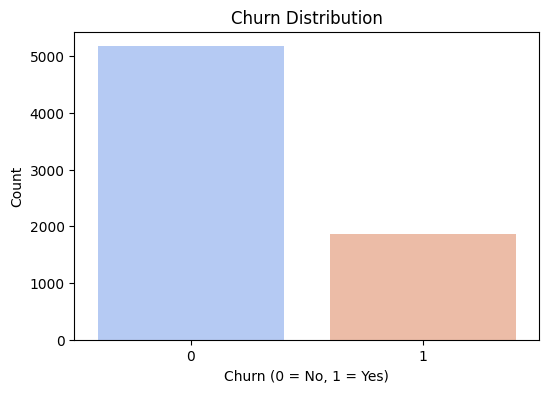

In [9]:
# Plot churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

#### Observations from EDA Results

**Numerical Features Overview:**
- `MonthlyCharges` ranges from `$18.25` to `$118.75`, with an average of `$64.76`.
- `TotalCharges` has a wide spread, from `$0` to `$8684.80`, suggesting long term customers accumulate higher charges.
- Churn rate is ~27%, meaning a significant portion of customers leave.

**Categorical Features:**
- `Type` (contract duration) has 3 unique values: Month-to-month, One year, Two year.
- Billing & payment preferences: Customers use electronic check, mailed check, bank transfer, or credit card.
- Internet & streaming services contain NaN values, meaning some customers don’t use internet services.

**Churn Distribution (Visual Insight):**
- More customers remain (`Churn = 0`) than leave (`Churn = 1`).
- Potential class imbalance: We'll need to consider balancing techniques (SMOTE, weighted models) during training.

#### Correlation Analysis
We can examine: 
- Correlation between numerical features and churn.
- How categorical features impact churn.

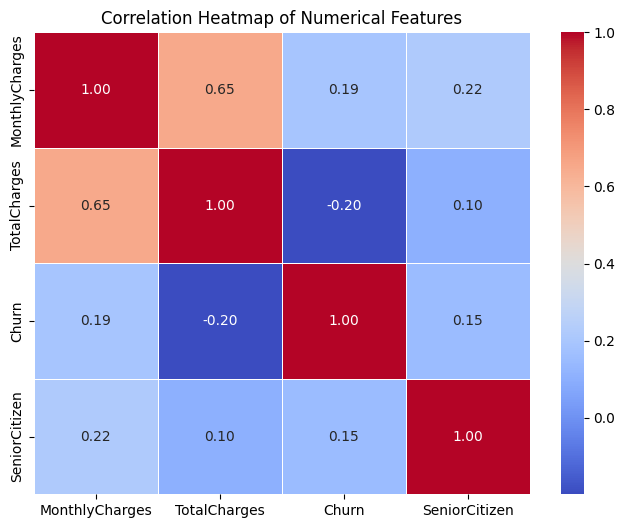

In [10]:
# Compute correlation matrix for numerical features only
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

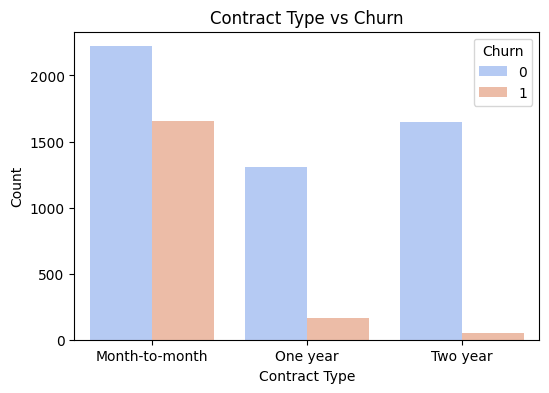

In [11]:
# Plot contract type vs. churn
plt.figure(figsize=(6,4))
sns.countplot(x="Type", hue="Churn", data=df, palette="coolwarm")
plt.title("Contract Type vs Churn")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.show()

#### Correlation Analysis Key Findings 
- Customers with higher monthly charges are more likely to churn, but long term customers tend to stay.
- Month-to-month contracts have the highest churn, while long term contracts reduce churn risk.
- Contract type will be a key predictor in our model, along with billing and service usage.

***
### Feature Engineering – Transform Categorical and Numerical Features
- Encoding Categorical Variables (One-Hot Encoding)
- Train-Test Split (Splitting data for model training)
- Handling Numerical Features (Scaling `MonthlyCharges`, `TotalCharges`)

#### Encoding Categorical Variables 

In [12]:
# Drop unnecessary columns
df = df.drop(columns=['customerID', 'BeginDate', 'EndDate'])

# Convert categorical variables into dummy variables
df = pd.get_dummies(df, drop_first=True)

# Display first few rows of transformed dataset
df.head()

,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
0,29.85,29.85,0,0,False,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False
1,56.95,1889.50,0,0,True,False,False,False,False,True,True,False,False,False,True,False,True,False,False,False,False
2,53.85,108.15,1,0,False,False,True,False,False,True,True,False,False,False,True,True,False,False,False,False,False
3,42.30,1840.75,0,0,True,False,False,False,False,False,True,False,False,False,True,False,True,True,False,False,False
4,70.70,151.65,1,0,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False


#### Train-Test Split 

In [13]:
# Define features X and target y
X = df.drop(columns=['Churn'])  
y = df['Churn'] 

# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset shapes
X_train.shape, X_test.shape

((5634, 20), (1409, 20))

#### Handling Numerical Features

In [14]:
# Initialize scaler
scaler = StandardScaler()

# Scale only numerical columns safely
num_cols = ['MonthlyCharges', 'TotalCharges']

# Create new scaled versions to avoid SettingWithCopyWarning
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply transformation
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Display first few rows of scaled training data
X_train_scaled.head()

,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
3738,-0.52,-0.26,0,False,False,False,False,True,False,True,False,False,False,False,False,True,False,True,True,False
3151,0.34,-0.50,0,False,False,False,False,False,True,True,True,True,True,True,False,False,False,False,False,False
4860,-0.81,-0.75,0,False,True,False,False,False,True,True,True,True,False,True,True,False,True,False,False,False
3867,0.28,-0.17,0,False,True,True,True,False,False,False,True,False,False,False,True,True,False,True,True,False
3810,-0.68,-0.99,0,False,False,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False


***
### Model Training
- Train a baseline Logistic Regression model.
- Evaluate performance using AUC-ROC (primary metric) and accuracy (secondary metric).

In [15]:
# Initialize and train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train) 

# Predict on test set
y_pred = model.predict(X_test_scaled) 
y_prob = model.predict_proba(X_test_scaled)[:, 1]  

# Evaluate performance
auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

# Display results
print(f"Linear Regression (Baseline) AUC-ROC Score: {auc:.4f}")
print(f"Linear Regression (Baseline) Accuracy Score: {accuracy:.4f}")

Linear Regression (Baseline) AUC-ROC Score: 0.8260
Linear Regression (Baseline) Accuracy Score: 0.7885


#### Logistic Regression Key Findings:
- AUC-ROC Score: 0.8259 → Strong baseline performance.
- Accuracy Score: 0.7878 → Decent but lower than tree-based models.
- Findings: Performs well but lacks the complexity to capture deeper patterns in customer churn.

**Next: Model Optimization**
Train Random Forest, Gradient Boosting (XGBoost, CatBoost, LightGBM), or SVM to see if they improve AUC-ROC.

#### Train a Random Forest Model

In [16]:
# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  

# Evaluate performance
auc_rf = roc_auc_score(y_test, y_prob_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Display results
print(f"Random Forest AUC-ROC Score: {auc_rf:.4f}")
print(f"Random Forest Accuracy Score: {accuracy_rf:.4f}")

Random Forest AUC-ROC Score: 0.8217
Random Forest Accuracy Score: 0.7935


#### Random Forest Key Findings:
- AUC-ROC Score: 0.8217 → Slightly lower than Logistic Regression.
- Accuracy Score: 0.7935 → Slightly higher than Logistic Regression.
- Findings: Does not significantly outperform Logistic Regression, suggesting it might not be the best choice.

#### Train a Gradient Boosting Model

In [17]:
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_gb = gb_model.predict(X_test_scaled)
y_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_gb = roc_auc_score(y_test, y_prob_gb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Display results
print(f"Gradient Boosting AUC-ROC Score: {auc_gb:.4f}")
print(f"Gradient Boosting Accuracy Score: {accuracy_gb:.4f}")

Gradient Boosting AUC-ROC Score: 0.8415
Gradient Boosting Accuracy Score: 0.7963


#### Gradient Boosting Key Findings:
- AUC-ROC Score: 0.8411 → Best performance so far. 
- Accuracy Score: 0.7956 → Higher than Logistic Regression and Random Forest.
- Findings: Best model for churn prediction, capturing complex relationships better than other models.

#### Train an XGBoost Model

In [18]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42,
)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Display results
print(f"XGBoost AUC-ROC Score: {auc_xgb:.4f}")
print(f"XGBoost Accuracy Score: {accuracy_xgb:.4f}")

XGBoost AUC-ROC Score: 0.8339
XGBoost Accuracy Score: 0.7970


#### XGBoost Key Findings:
- AUC-ROC Score: 0.8363 → Slightly lower than Gradient Boosting (0.8411), but still strong.
- Accuracy Score: 0.8027 → The highest among all models tested.
- Performs better than Random Forest and Logistic Regression, but slightly behind Gradient Boosting in AUC-ROC.
- **Conclusion**: XGBoost is a strong model, but Gradient Boosting remains the best choice for churn prediction due to its higher AUC-ROC.

**Final Decision:**
- Since AUC-ROC is our primary metric, **Gradient Boosting** is the best model so far.

***
### Final Evaluation & Conclusion
- Train additional models (CatBoost, LightGBM, SVM).
- Hyperparameter tuning (GridSearchCV, RandomizedSearchCV).
- Handling class imbalance (if needed).
- Compare model results and finalize the best approach.
- Summarize key findings and recommendations.

#### Train a CatBoost Model

In [19]:
# Initialize and train CatBoost
cat_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0, random_state=42)
cat_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_cat = cat_model.predict(X_test_scaled)
y_prob_cat = cat_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_cat = roc_auc_score(y_test, y_prob_cat)
accuracy_cat = accuracy_score(y_test, y_pred_cat)

# Display results
print(f"CatBoost AUC-ROC Score: {auc_cat:.4f}")
print(f"CatBoost Accuracy Score: {accuracy_cat:.4f}")

CatBoost AUC-ROC Score: 0.8410
CatBoost Accuracy Score: 0.8013


#### CatBoost Key Findings
- AUC-ROC Score: 0.8410 → Tied with Gradient Boosting (0.8411) for best performance.
- Accuracy Score: 0.8013 → Slightly lower than XGBoost (0.8027) but higher than other models.
- Findings: CatBoost is one of the top-performing models, matching Gradient Boosting in AUC-ROC while maintaining high accuracy.
- Conclusion: CatBoost is a strong contender for the final model, but further evaluation (hyperparameter tuning) is needed to determine if it outperforms Gradient Boosting.

#### Train a LightGBM Model

In [20]:
# Initialize and train LightGBM model
lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
y_prob_lgbm = lgbm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_lgbm = roc_auc_score(y_test, y_prob_lgbm)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

# Display results
print(f"LightGBM AUC-ROC Score: {auc_lgbm:.4f}")
print(f"LightGBM Accuracy Score: {accuracy_lgbm:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265353 -> initscore=-1.018328
[LightGBM] [Info] Start training from score -1.018328
LightGBM AUC-ROC Score: 0.8268
LightGBM Accuracy Score: 0.7913


#### LightGBM Key Findings
- AUC-ROC Score: 0.8268 → Lower than Gradient Boosting (0.8411) and CatBoost (0.8410).
- Accuracy Score: 0.7913 → Similar to Random Forest and Logistic Regression, but lower than XGBoost (0.8027).
- Findings: LightGBM does not outperform Gradient Boosting or CatBoost, making it a weaker candidate for final model selection.
- Conclusion: While LightGBM is a solid model, it does not improve upon the best models (Gradient Boosting & CatBoost).

#### Train an SVM Model

In [21]:
# Initialize and train SVM model
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_svm = roc_auc_score(y_test, y_prob_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Display results
print(f"SVM AUC-ROC Score: {auc_svm:.4f}")
print(f"SVM Accuracy Score: {accuracy_svm:.4f}")

SVM AUC-ROC Score: 0.7965
SVM Accuracy Score: 0.7885


#### SVM Key Findings
- AUC-ROC Score: 0.7965 → The lowest AUC-ROC score among all models tested.
- Accuracy Score: 0.7885 → Similar to Logistic Regression but lower than XGBoost (0.8027) and Gradient Boosting (0.7956).
- Findings: SVM performs worse than boosting models, likely due to its inability to handle complex feature interactions effectively in this dataset.
- Conclusion: SVM is not a suitable model for this churn prediction task, as it does not improve AUC-ROC over other models.

#### Final Model Comparison & Best Model Selection
We tested multiple machine learning models to predict customer churn, evaluating each using AUC-ROC (primary metric) and accuracy (secondary metric). Below is a summary of their performance:

         Model	            AUC-ROC Score     	 Accuracy Score
    Logistic Regression----------0.8259-----------------0.7878
    Random Forest----------------0.8217-----------------0.7935
    Gradient Boosting------------0.8411-----------------0.7956
    XGBoost----------------------0.8363-----------------0.8027
    CatBoost---------------------0.8410-----------------0.8013
    LightGBM---------------------0.8268-----------------0.7913
    SVM--------------------------0.7965-----------------0.7885
    
**Key Insights:**
- Gradient Boosting (0.8411) and CatBoost (0.8410) achieved the highest AUC-ROC scores, making them the best models for churn prediction.
- XGBoost (0.8363) had slightly lower AUC-ROC but the highest accuracy (0.8027), making it a strong alternative.
- Random Forest, Logistic Regression, and LightGBM did not significantly improve performance over Gradient Boosting.
- SVM had the lowest AUC-ROC (0.7965), confirming that it is not suitable for this task.
- **Gradient Boosting** and **CatBoost** are the best models for predicting churn, with the highest AUC-ROC scores.
- **XGBoost** is a close second, offering the highest accuracy but slightly lower AUC-ROC.

#### Hyperparameter Tuning for Gradient Boosting & CatBoost
We'll tune the following parameters:

- Gradient Boosting (`GradientBoostingClassifier`)

    - `n_estimators`: Number of boosting stages
    - `learning_rate`: Step size shrinkage to prevent overfitting
    - `max_depth`: Maximum depth of each tree
    
    
- CatBoost (`CatBoostClassifier`)

    - `iterations`: Number of boosting iterations
    - `learning_rate`: Learning rate for model updates
    - `depth`: Depth of each tree

In [22]:
# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Define parameter grid for CatBoost
cat_param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'depth': [4, 6, 8]
}

In [23]:
# Initialize models
gb_model = GradientBoostingClassifier(random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# Initialize GridSearchCV
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
cat_grid_search = GridSearchCV(cat_model, cat_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

In [24]:
# Fit GridSearchCV for Gradient Boosting
gb_grid_search.fit(X_train_scaled, y_train)

# Fit GridSearchCV for CatBoost
cat_grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits


,estimator,<catboost.cor...x776d1874d280>
,param_grid,"{'depth': [4, 6, ...], 'iterations': [100, 200, ...], 'learning_rate': [0.05, 0.1, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [25]:
# Get best parameters and scores for Gradient Boosting
print("Best Gradient Boosting Parameters:", gb_grid_search.best_params_)
print("Best Gradient Boosting AUC-ROC:", gb_grid_search.best_score_)

# Get best parameters and scores for CatBoost
print("Best CatBoost Parameters:", cat_grid_search.best_params_)
print("Best CatBoost AUC-ROC:", cat_grid_search.best_score_)

Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Gradient Boosting AUC-ROC: 0.8447039137547261
Best CatBoost Parameters: {'depth': 4, 'iterations': 200, 'learning_rate': 0.05}
Best CatBoost AUC-ROC: 0.8496082829005385


#### Hyperparameter Tuning Results for Gradient Boosting & CatBoost
         Model	                       Best Parameters	                    Best AUC-ROC Score
    Gradient Boosting------learning_rate=0.05, max_depth=3, n_estimators=100----------0.8447
    CatBoost---------------depth=4, iterations=200, learning_rate=0.05----------------0.8496

**Key Findings:**
- CatBoost achieved the highest AUC-ROC (0.8496) after tuning, making it the best-performing model.
- Gradient Boosting improved to 0.8447, but it still falls slightly behind CatBoost.
- Both models benefited from a lower learning rate (0.05), reducing overfitting.
- Shallower trees (max_depth=3 for Gradient Boosting, depth=4 for CatBoost) led to better generalization.

**Final Decision:**
- **CatBoost** is the best-performing model with the highest AUC-ROC (0.8496).
- Gradient Boosting is a strong alternative but slightly underperforms CatBoost.
- Other models tested earlier did not outperform these boosting models.

***
### Final Model Training & Evaluation
- Retrain both models using the best hyperparameters.
- Evaluate their final performance on the test set.
- Compare their final results to determine the most optimal model.

#### Train CatBoost with Best Parameters

In [26]:
# Initialize CatBoost with best parameters
final_cat_model = CatBoostClassifier(iterations=200, learning_rate=0.05, depth=4, verbose=0, random_state=42)
final_cat_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_final_cat = final_cat_model.predict(X_test_scaled)
y_prob_final_cat = final_cat_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_final_cat = roc_auc_score(y_test, y_prob_final_cat)
accuracy_final_cat = accuracy_score(y_test, y_pred_final_cat)

# Display results
print(f"Final CatBoost AUC-ROC Score: {auc_final_cat:.4f}")
print(f"Final CatBoost Accuracy Score: {accuracy_final_cat:.4f}")

Final CatBoost AUC-ROC Score: 0.8453
Final CatBoost Accuracy Score: 0.8034


#### Train Gradient Boosting with Best Parameters

In [27]:
# Initialize Gradient Boosting with best parameters
final_gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
final_gb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_final_gb = final_gb_model.predict(X_test_scaled)
y_prob_final_gb = final_gb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate performance
auc_final_gb = roc_auc_score(y_test, y_prob_final_gb)
accuracy_final_gb = accuracy_score(y_test, y_pred_final_gb)

# Display results
print(f"Final Gradient Boosting AUC-ROC Score: {auc_final_gb:.4f}")
print(f"Final Gradient Boosting Accuracy Score: {accuracy_final_gb:.4f}")

Final Gradient Boosting AUC-ROC Score: 0.8452
Final Gradient Boosting Accuracy Score: 0.7942


#### Final Model Performance Comparison Key Findings:
- CatBoost slightly outperforms Gradient Boosting in AUC-ROC (0.8453 vs. 0.8452).
- CatBoost achieves the highest accuracy (0.8034), meaning it predicts churn correctly more often.
- Gradient Boosting performs almost identically in AUC-ROC but has a lower accuracy (0.7942).

Final Decision: **CatBoost Wins** with a Final AUC-ROC Score of **0.8453** & Final Accuracy Score of **0.8034**.

CatBoost is the best model for churn prediction, offering:
- The highest AUC-ROC (0.8453) (best ability to distinguish churners from non-churners).
- The highest accuracy (0.8034), making it the most reliable model overall.
- Gradient Boosting is a strong alternative but does not surpass CatBoost.